In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install tsfresh
# !pip install scapy

In [ ]:
pip install tsfresh

In [7]:
pip install scapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444345 sha256=30666e07bdfedc3efbb069fcd6f8d3511da74d2754106fd34800822d26fd7f7f
  Stored in directory: /root/.cache/pip/wheels/dd/1b/47/d46b1a87e339be501612cf4cd1bf57742e534f9c9aac7b00d6
Successfully built scapy


In [22]:
import pandas as pd
import tsfresh
import os
import json
import scapy
import numpy as np
import warnings
from timeit import default_timer as timer
from scapy.all import *

import sys
from pathlib import Path
import seaborn as sns
warnings.filterwarnings("ignore") 
import pandas as pd
import tsfresh
import os
import json
import scapy
import numpy as np
import warnings
from timeit import default_timer as timer
from scapy.all import *
warnings.filterwarnings("ignore")
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from sklearn import neighbors, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])
df_results = pd.DataFrame()

In [13]:
def run_process(a,b,x, changed_mal):
    
    df_malicious = a.copy()
    df_benign    = b.copy()
    
    df_mal_web_mine = changed_mal.copy()

    from tsfresh import extract_features, select_features
    from tsfresh.utilities.dataframe_functions import impute
    from tsfresh import extract_features
    from tsfresh.feature_selection.relevance import calculate_relevance_table

    df_malicious.reset_index(drop=True, inplace=True) #reset index
    df_malicious['id']= np.floor(df_malicious.index.array/10)
    df_benign.reset_index(drop=True, inplace=True) #reset index
    df_benign['id']= np.floor(df_benign.index.array/10)

    df_mal_web_mine.reset_index(drop=True, inplace=True) #reset index
    df_mal_web_mine['id']= np.floor(df_mal_web_mine.index.array/10)
    
    tf1=tsfresh.extract_features(df_malicious,impute_function=impute, column_kind='Is_malicious',
                                 column_id='id',column_sort="Time",column_value = "Length")
    tf1['class']= 1

    tf2=tsfresh.extract_features(df_benign,impute_function=impute, column_kind='Is_malicious',
                                 column_id='id',column_sort="Time",column_value = "Length")
    tf2['class']= 0

    tf3=tsfresh.extract_features(df_mal_web_mine,impute_function=impute, column_kind='Is_malicious',
                                 column_id='id',column_sort="Time",column_value = "Length")
    tf3['class']= 1

    tf2.columns = tf1.columns
    tf3.columns = tf1.columns

    features=pd.concat([tf1,tf2])
    features_changed_mal = pd.concat([tf3,tf2])

    features2 = features.copy()
    features_changed_mal2 = features_changed_mal.copy()

    features2.reset_index(drop=True, inplace=True)
    features_changed_mal2.reset_index(drop=True, inplace=True)

    y = pd.Series(data = features2['class'], index=features2.index)
    y_changed_mal = pd.Series(data = features_changed_mal2['class'], index=features_changed_mal2.index)

    from tsfresh.examples import load_robot_execution_failures
    from tsfresh import extract_features, select_features
    from tsfresh.feature_selection.relevance import calculate_relevance_table

    relevance_table = calculate_relevance_table(features2, y)
    relevance_table = relevance_table[relevance_table.relevant]
    relevance_table.sort_values("p_value", inplace=True)
    print("relevance_table " , relevance_table.shape)
    relevance_table_changed_mal = calculate_relevance_table(features_changed_mal2, y_changed_mal)
    relevance_table_changed_mal = relevance_table_changed_mal[relevance_table_changed_mal.relevant]
    relevance_table_changed_mal.sort_values("p_value", inplace=True)
    print("relevance_table_changed_mal " , relevance_table_changed_mal.shape)

    best_features = pd.DataFrame(relevance_table[relevance_table['p_value'] <= 0.05])
    # print("best_features " , best_features.shape)
    # print("best_features features" , best_features.feature)

    mal_pktPlus_features = pd.DataFrame(relevance_table_changed_mal)

    if (len(mal_pktPlus_features) >= len(best_features)):
      mal_pktPlus_features = mal_pktPlus_features[:len(best_features)]
    else:
      best_features = best_features[:len(mal_pktPlus_features)]
      # mal_pktPlus_features = pd.concat([mal_pktPlus_features, best_features[~best_features.feature.isin(mal_pktPlus_features.feature)]])
      # mal_pktPlus_features = mal_pktPlus_features.iloc[:len(best_features)]
    df_ML = pd.DataFrame()
    df_ML_mal = pd.DataFrame()

    for pkt in best_features:
        df_ML[best_features.feature] = features[best_features.feature]
        # df_ML_mal[best_features.feature] = features_changed_mal2[mal_pktPlus_features.feature]
      
    for pkt in mal_pktPlus_features:
        df_ML_mal[mal_pktPlus_features.feature] = features_changed_mal2[mal_pktPlus_features.feature]
    # mal_pktPlus_features.feature = relevance_table_changed_mal.feature

    # print("mal_pktPlus_features " , mal_pktPlus_features.shape)
    # print("mal_pktPlus_features features" , mal_pktPlus_features.feature)

    # df_ML.columns = df_ML_mal.columns    

    final = ML_Process(df_ML,x, df_ML_mal)

    return final

In [39]:
def ML_Process(df_ML,x, df_ML_mal):
    df_results = x.copy() 
    print('let the ml starts')
  
    from sklearn import neighbors, metrics
    from sklearn.preprocessing import LabelEncoder

    #X = df_finalized[['Time', 'Length','Protocol']].values
    X = df_ML.drop('class',axis=1).to_numpy()
    X_mal = df_ML_mal.drop('class',axis=1).to_numpy()
    #y = df_finalized[['Is_malicious']]
    y = df_ML['class'].to_numpy()
    y_mal = df_ML_mal['class'].to_numpy()

    #print(X,y)
    
    # from sklearn.model_selection import train_test_split
    Le = LabelEncoder()
    for i in range(len(X[0])):
        X[:, i] = Le.fit_transform(X[:, i])
    for i in range(len(X_mal[0])):
        X_mal[:, i] = Le.fit_transform(X_mal[:, i])
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8675309)
    X_train = X
    y_train = y
    X_test = X_mal
    y_test = y_mal

    from sklearn.svm import SVC
    from sklearn import model_selection
    from sklearn.utils import class_weight
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import pandas as pd
    y_train = y_train.ravel()
    # dfs = []
    models = [('LogReg', LogisticRegression()), 
              ('KNN', KNeighborsClassifier()),
              ('SVM', SVC()), 
              ('GNB', GaussianNB())]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    # for name, model in models:
    #     kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=None)
    #     cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, 
    #                                                 scoring=scoring)
    #     clf = model.fit(X_train, y_train)
    #     y_pred = clf.predict(X_test)
    #     print(name)
    #     print(classification_report(y_test, y_pred, target_names=target_names))
    #     results.append(cv_results)
    #     names.append(name)
    #     this_df = pd.DataFrame(cv_results)
    #     this_df['model'] = name
    #     dfs.append(this_df)
    #     df_resulta = df_results.append(dfs)
    #     final = pd.concat(dfs, ignore_index=True)
    #     plt.show()
    # plt.figure(figsize=(10,5))
    # sns.barplot(x='model', y='test_accuracy', data=final, ci=None)
    # plt.title('Mean Accuracy by Model')
    # plt.xlabel('Model')
    # plt.ylabel('Mean Test Accuracy')   
    # return(final)
    dfs = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=None)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, 
                                                    scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
        print(report)
        accuracy = report['accuracy']  # Get accuracy from the classification report
        this_df = pd.DataFrame({'model': [name], 'accuracy': [accuracy]})  # Store accuracy in a DataFrame
        dfs.append(this_df)

    final = pd.concat(dfs, ignore_index=True)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='model', y='accuracy', data=final, ci=None)  # Use 'accuracy' instead of 'test_accuracy'
    plt.title('Accuracy by Model')
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy')
    plt.ylim(0, 1)
    plt.show()

    return final

In [25]:
def plot_metrics(df):
    melted_df = pd.melt(df, id_vars=['model', 'test_accuracy'], value_vars=['test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted', 'test_roc_auc'], var_name='metric', value_name='score')

    g = sns.FacetGrid(melted_df, col='metric', sharey=False, height=4, aspect=1.2)
    g.map(sns.barplot, 'model', 'score', order=['LogReg', 'KNN', 'SVM', 'GNB'], palette='Blues_d', ci=None)
    g.set_titles("{col_name}")
    g.set_axis_labels("", "Score")
    g.set_xticklabels(rotation=45)
    g.set(ylim=(0, 1))

    for ax in g.axes.flat:
        ax.axhline(df.test_accuracy.mean(), ls='--', color='gray', lw=1)
        return g
    

In [ ]:
 def insertion(df, interval):
  df.reset_index(drop=True)
  timeline = df['Time'].astype(int).unique()
  insert_packet = pd.DataFrame([['Time', 'sip', 'dip', 'proto', 74, 'hw_src', 'hw_dst', 1]], columns = df_malicious.columns)

  for i in range(len(timeline)):
    if ((timeline[i] % interval) == 0):
      insert_packet['Time'] = timeline[i]
      df = pd.concat([df, insert_packet], ignore_index = True)

In [ ]:
def fragment_man(df, split_val):
  split = pd.DataFrame(columns = df.columns)
  split_value = split_val

  for i in range(len(df)):
    if (df['Length'].iloc[i] > split_value):
      df['Length'].iloc[i] = split_value
      for j in range((df['Length'].iloc[i].astype(int) // split_value)):
        df = df.append(df.iloc[i], ignore_index = True)

##### PERTURBATION (Single Method)

DUMMMY PACKET


0 NAN in malicious
0 NAN in benign


Feature Extraction: 100%|██████████| 6186/6186 [03:51<00:00, 26.77it/s]


relevance_table  (255, 4)
relevance_table_changed_mal  (251, 4)
let the ml starts
LogReg
{'malignant': {'precision': 0.30392684238838086, 'recall': 0.1805111821086262, 'f1-score': 0.22649829625175388, 'support': 6260}, 'benign': {'precision': 0.4122364802933089, 'recall': 0.5816359521500162, 'f1-score': 0.4824996647445354, 'support': 6186}, 'accuracy': 0.37988108629278483, 'macro avg': {'precision': 0.35808166134084485, 'recall': 0.38107356712932117, 'f1-score': 0.35449898049814466, 'support': 12446}, 'weighted avg': {'precision': 0.3577596738265847, 'recall': 0.37988108629278483, 'f1-score': 0.3537379287036538, 'support': 12446}}
KNN
{'malignant': {'precision': 0.7395075545607163, 'recall': 0.844408945686901, 'f1-score': 0.7884844868735084, 'support': 6260}, 'benign': {'precision': 0.816157040392601, 'recall': 0.6989977368250889, 'f1-score': 0.7530477185649599, 'support': 6186}, 'accuracy': 0.7721356259039048, 'macro avg': {'precision': 0.7778322974766586, 'recall': 0.7717033412559949

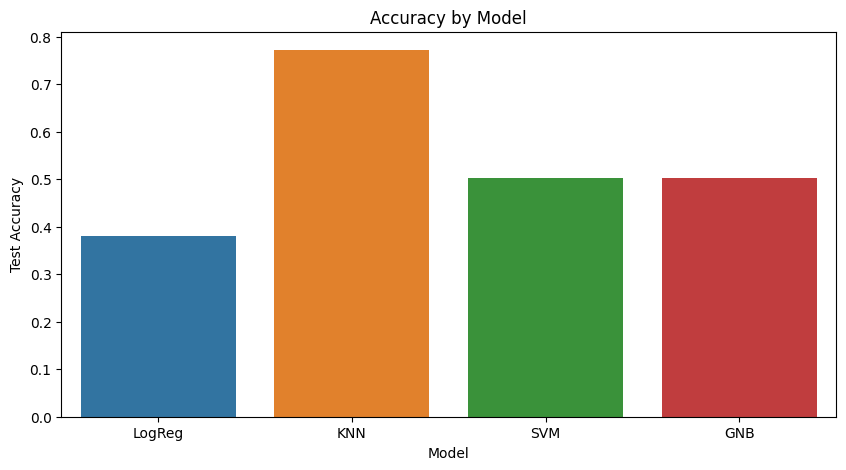

794.1731237879999


In [32]:
### DUMMY PACKET
df_malicious = pd.read_csv('/content/drive/MyDrive/attacked_data/conventional_malicious_traffic.csv', index_col = [0])
df_benign = pd.read_csv('/content/drive/MyDrive/attacked_data/benign_traffic.csv', index_col = [0])
df_mal_web_mine = pd.read_csv('/content/drive/MyDrive/attacked_data/single_method/dummy_packet.csv', index_col = [0])

print("{} NAN in malicious".format(len(df_malicious[df_malicious.isna().any(axis=1)])))
print("{} NAN in benign".format(len(df_benign[df_benign.isna().any(axis=1)])))

df_malicious = df_malicious.dropna()
df_benign = df_benign.dropna()

start = timer()
results_Raspberry_s1 = run_process(df_malicious,df_benign,df_results, df_mal_web_mine)
end = timer()
print(end - start)

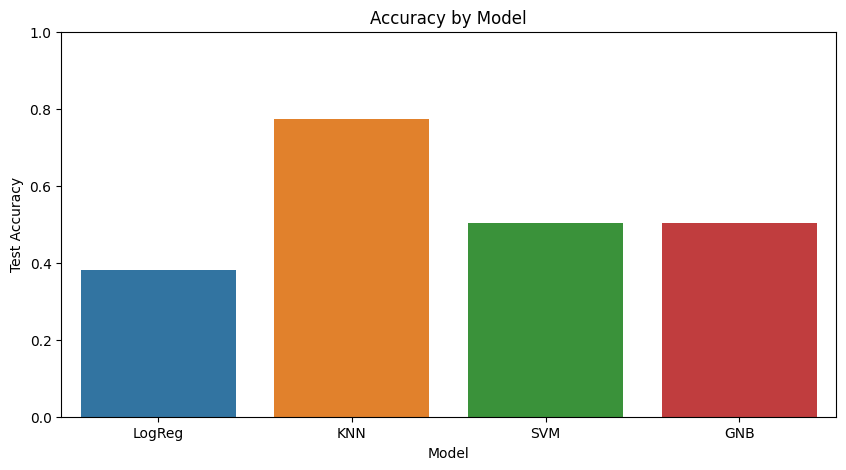

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store the accuracy values in a DataFrame
data = {'model': ['LogReg', 'KNN', 'SVM', 'GNB'],
        'accuracy': [0.37988108629278483, 0.7721356259039048, 0.5029728426803792, 0.5032942310782581]}

accuracy_df = pd.DataFrame(data)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='accuracy', data=accuracy_df, ci=None)
plt.title('Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit to 1
plt.show()


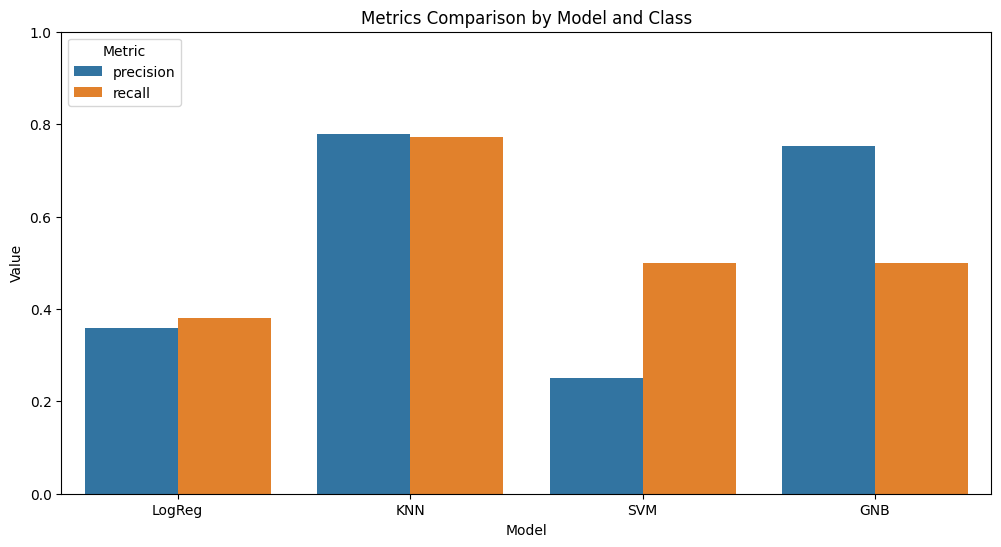

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store the metrics values in a DataFrame
data = {'model': ['LogReg', 'LogReg', 'LogReg', 'LogReg', 'KNN', 'KNN', 'KNN', 'KNN', 'SVM', 'SVM', 'SVM', 'SVM', 'GNB', 'GNB', 'GNB', 'GNB'],
        'class': ['malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'benign', 'benign'],
        'metric': ['precision', 'recall', 'precision', 'recall', 'precision', 'recall', 'precision', 'recall', 'precision', 'recall', 'precision', 'recall', 'precision', 'recall', 'precision', 'recall'],
        'value': [0.30392684238838086, 0.1805111821086262, 0.4122364802933089, 0.5816359521500162,
                  0.7395075545607163, 0.844408945686901, 0.816157040392601, 0.6989977368250889,
                  0.5029728426803792, 1.0, 0.0, 0.0,
                  0.5031345442854847, 1.0, 1.0, 0.0006466214031684449]}

metrics_df = pd.DataFrame(data)

# Create a grouped bar plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='value', hue='metric', data=metrics_df, ci=None)
plt.title('Metrics Comparison by Model and Class')
plt.xlabel('Model')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title='Metric', loc='upper left')
plt.show()


Padding

0 NAN in malicious
0 NAN in benign


Feature Extraction: 100%|██████████| 6055/6055 [03:52<00:00, 26.06it/s]


relevance_table  (255, 4)
relevance_table_changed_mal  (258, 4)
let the ml starts
LogReg
{'malignant': {'precision': 0.6409164172231177, 'recall': 0.889297124600639, 'f1-score': 0.7449484811989829, 'support': 6260}, 'benign': {'precision': 0.8090383025626895, 'recall': 0.48488852188274156, 'f1-score': 0.6063610078479968, 'support': 6055}, 'accuracy': 0.6904587900933821, 'macro avg': {'precision': 0.7249773598929036, 'recall': 0.6870928232416903, 'f1-score': 0.67565474452349, 'support': 12315}, 'weighted avg': {'precision': 0.7235780506564192, 'recall': 0.6904587900933821, 'f1-score': 0.6768082334409463, 'support': 12315}}
KNN
{'malignant': {'precision': 0.6987319632706602, 'recall': 0.765814696485623, 'f1-score': 0.7307369865101744, 'support': 6260}, 'benign': {'precision': 0.7312064539787312, 'recall': 0.6586292320396366, 'f1-score': 0.6930228516812929, 'support': 6055}, 'accuracy': 0.7131140885099472, 'macro avg': {'precision': 0.7149692086246957, 'recall': 0.7122219642626297, 'f1-sc

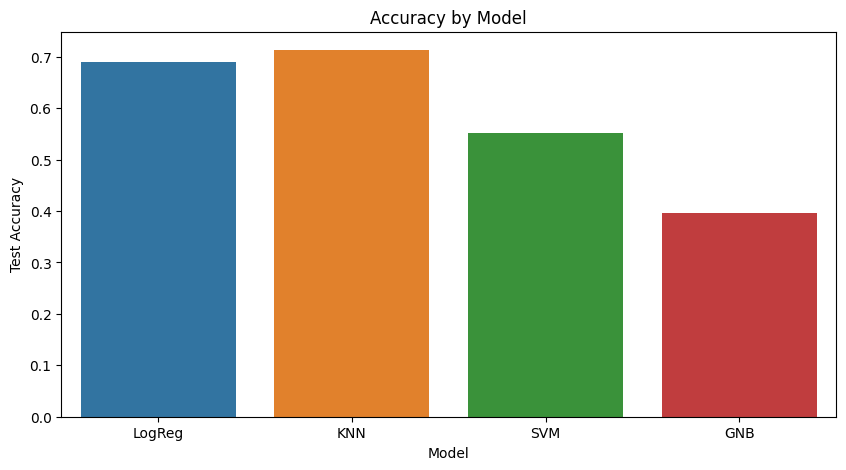

837.490857234


In [36]:
### PADDING
df_malicious = pd.read_csv('/content/drive/MyDrive/attacked_data/conventional_malicious_traffic.csv', index_col = [0])
df_benign = pd.read_csv('/content/drive/MyDrive/attacked_data/benign_traffic.csv', index_col = [0])
df_mal_web_mine = pd.read_csv('/content/drive/MyDrive/attacked_data/single_method/padding.csv', index_col = [0])
print("{} NAN in malicious".format(len(df_malicious[df_malicious.isna().any(axis=1)])))
print("{} NAN in benign".format(len(df_benign[df_benign.isna().any(axis=1)])))

df_malicious = df_malicious.dropna()
df_benign = df_benign.dropna()

start = timer()
results_Raspberry_s1 = run_process(df_malicious,df_benign,df_results, df_mal_web_mine)
end = timer()
print(end - start)

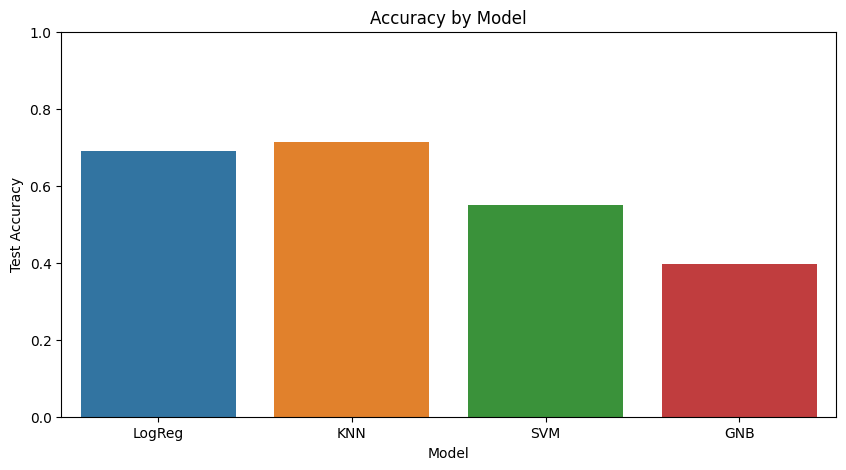

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store the accuracy values in a DataFrame
data = {'model': ['LogReg', 'KNN', 'SVM', 'GNB'],
        'accuracy': [0.6904587900933821, 0.7131140885099472, 0.5511165245635404, 0.3969143321153065]}

accuracy_df = pd.DataFrame(data)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='accuracy', data=accuracy_df, ci=None)
plt.title('Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit to 1
plt.show()


-------------------Splitting-----------------------
# 

0 NAN in malicious
0 NAN in benign


Feature Extraction: 100%|██████████| 6305/6305 [04:25<00:00, 23.72it/s]


relevance_table  (255, 4)
relevance_table_changed_mal  (258, 4)
let the ml starts
LogReg
{'malignant': {'precision': 0.5637062019861345, 'recall': 0.9611821086261981, 'f1-score': 0.7106413133341207, 'support': 6260}, 'benign': {'precision': 0.8714965626652564, 'recall': 0.26137985725614593, 'f1-score': 0.4021473889702294, 'support': 6305}, 'accuracy': 0.6100278551532033, 'macro avg': {'precision': 0.7176013823256955, 'recall': 0.6112809829411721, 'f1-score': 0.5563943511521751, 'support': 12565}, 'weighted avg': {'precision': 0.7181525389604173, 'recall': 0.6100278551532033, 'f1-score': 0.5558419346541099, 'support': 12565}}
KNN
{'malignant': {'precision': 0.5941673062164237, 'recall': 0.618370607028754, 'f1-score': 0.606027397260274, 'support': 6260}, 'benign': {'precision': 0.6051239669421488, 'recall': 0.5806502775574941, 'f1-score': 0.5926345609065156, 'support': 6305}, 'accuracy': 0.5994428969359331, 'macro avg': {'precision': 0.5996456365792862, 'recall': 0.5995104422931241, 'f1-

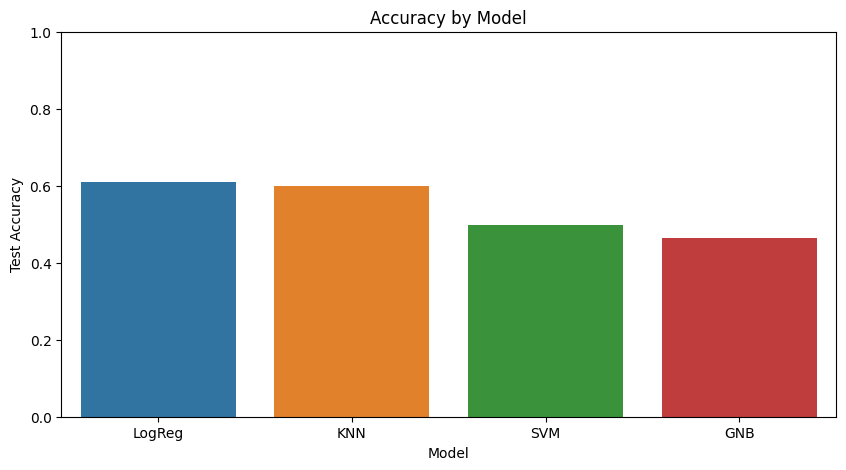

858.3521570029998


In [45]:
### SPLITTING
df_malicious = pd.read_csv('/content/drive/MyDrive/attacked_data/conventional_malicious_traffic.csv', index_col = [0])
df_benign = pd.read_csv('/content/drive/MyDrive/attacked_data/benign_traffic.csv', index_col = [0])
df_mal_web_mine = pd.read_csv('/content/drive/MyDrive/attacked_data/single_method/splitting.csv', index_col = [0])

print("{} NAN in malicious".format(len(df_malicious[df_malicious.isna().any(axis=1)])))
print("{} NAN in benign".format(len(df_benign[df_benign.isna().any(axis=1)])))

df_malicious = df_malicious.dropna()
df_benign = df_benign.dropna()

start = timer()
results_Raspberry_s1 = run_process(df_malicious,df_benign,df_results, df_mal_web_mine)
end = timer()
print(end - start)

0 NAN in malicious
0 NAN in benign


Feature Extraction: 100%|██████████| 6858/6858 [04:25<00:00, 25.87it/s]


relevance_table  (255, 4)
relevance_table_changed_mal  (260, 4)
let the ml starts
LogReg
{'malignant': {'precision': 0.34614247709133905, 'recall': 0.18706070287539936, 'f1-score': 0.24287047599294825, 'support': 6260}, 'benign': {'precision': 0.47724704673857216, 'recall': 0.6774569845435987, 'f1-score': 0.559995178689809, 'support': 6858}, 'accuracy': 0.4434364994663821, 'macro avg': {'precision': 0.4116947619149556, 'recall': 0.432258843709499, 'f1-score': 0.40143282734137864, 'support': 13118}, 'weighted avg': {'precision': 0.4146830426227253, 'recall': 0.4434364994663821, 'f1-score': 0.4086610851631778, 'support': 13118}}
KNN
{'malignant': {'precision': 0.5630084201512773, 'recall': 0.6301916932907349, 'f1-score': 0.5947086756614155, 'support': 6260}, 'benign': {'precision': 0.621174930453281, 'recall': 0.5535141440653252, 'f1-score': 0.5853959441745701, 'support': 6858}, 'accuracy': 0.5901051989632566, 'macro avg': {'precision': 0.5920916753022791, 'recall': 0.59185291867803, 'f1

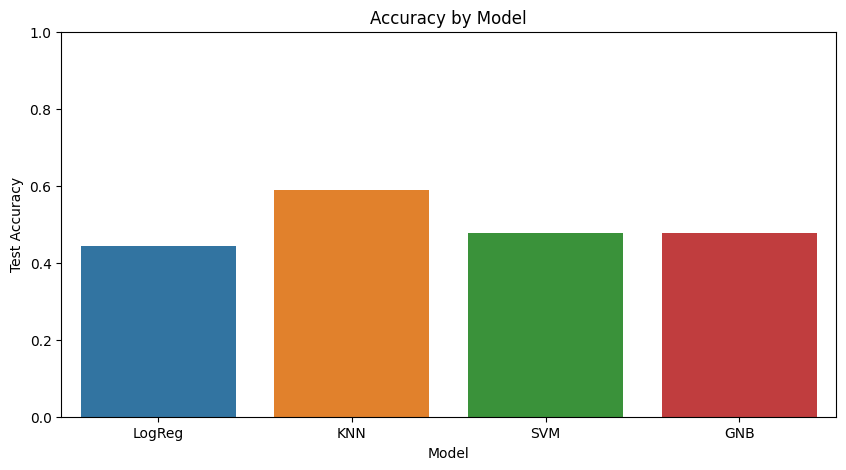

849.6663090870006


In [50]:
### OBFS4 PROXY
df_malicious = pd.read_csv('/content/drive/MyDrive/attacked_data/conventional_malicious_traffic.csv', index_col = [0])
df_benign = pd.read_csv('/content/drive/MyDrive/attacked_data/benign_traffic.csv', index_col = [0])
df_mal_web_mine = pd.read_csv('/content/drive/MyDrive/attacked_data/single_method/obfs4_mining.csv', index_col = [0])

print("{} NAN in malicious".format(len(df_malicious[df_malicious.isna().any(axis=1)])))
print("{} NAN in benign".format(len(df_benign[df_benign.isna().any(axis=1)])))

df_malicious = df_malicious.dropna()
df_benign = df_benign.dropna()

start = timer()
results_Raspberry_s1 = run_process(df_malicious,df_benign,df_results, df_mal_web_mine)
end = timer()
print(end - start)